In [1]:
!gdown --id 1pm50hZr3nLy0aYlsv88iXpJRkdm_NxM1

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:139: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1pm50hZr3nLy0aYlsv88iXpJRkdm_NxM1
To: /content/financial-news-data.zip
100% 952k/952k [00:00<00:00, 11.4MB/s]


In [2]:
!unzip financial-news-data.zip

Archive:  financial-news-data.zip
  inflating: financial-news-test.csv  
  inflating: __MACOSX/._financial-news-test.csv  
  inflating: financial-news-train.csv  
  inflating: __MACOSX/._financial-news-train.csv  


# Preparation

## Load data

In [3]:
import pandas as pd

train_df = pd.read_csv("/content/financial-news-train.csv")
test_df = pd.read_csv("/content/financial-news-test.csv")

train_df.head(5)

,text,label
0,Here are Thursday's biggest analyst calls: App...,Analyst Update
1,Buy Las Vegas Sands as travel to Singapore bui...,Analyst Update
2,"Piper Sandler downgrades DocuSign to sell, cit...",Analyst Update
3,"Analysts react to Tesla's latest earnings, bre...",Analyst Update
4,Netflix and its peers are set for a ‘return to...,Analyst Update


## Info of each set of data

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16990 entries, 0 to 16989
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    16990 non-null  object
 1   label   16990 non-null  object
dtypes: object(2)
memory usage: 265.6+ KB


In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4117 entries, 0 to 4116
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    4117 non-null   object
 1   label   4117 non-null   object
dtypes: object(2)
memory usage: 64.5+ KB


## Explore data

In [7]:
train_df['label'].unique()

array(['Analyst Update', 'Company | Product News',
       'General News | Opinion', 'Currencies', 'Dividend', 'Earnings',
       'Energy | Oil', 'Fed | Central Banks', 'Financials',
       'Gold | Metals | Materials', 'IPO', 'Legal | Regulation',
       'M&A | Investments', 'Macro', 'Markets', 'Personnel Change',
       'Politics', 'Stock Commentary', 'Stock Movement',
       'Treasuries | Corporate Debt'], dtype=object)

In [8]:
train_df['label'].value_counts()

,count
label,
Company | Product News,3545
Stock Commentary,2118
Macro,1822
General News | Opinion,1557
Earnings,987
Politics,985
Fed | Central Banks,837
Stock Movement,823
Financials,624


## Preprocess data

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_df['text'], train_df['label'],
                                                    random_state=42, 
                                                    test_size=0.1, 
                                                    shuffle=True, 
)

In [25]:
y_train.value_counts()

,count
label,
Company | Product News,3207
Stock Commentary,1899
Macro,1638
General News | Opinion,1407
Politics,902
Earnings,872
Stock Movement,754
Fed | Central Banks,737
Financials,555


In [26]:
y_test.value_counts()

,count
label,
Company | Product News,338
Stock Commentary,219
Macro,184
General News | Opinion,150
Earnings,115
Fed | Central Banks,100
Politics,83
Financials,69
Stock Movement,69


### Train set

In [27]:
from sklearn.feature_extraction.text import CountVectorizer
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Get the list of Thai stopwords
stop_words = list(stopwords.words('english'))

# Create bag-of-word
vectorizer = CountVectorizer(
    tokenizer=word_tokenize,
    stop_words=stop_words,
)
train_feature_vectors = vectorizer.fit_transform(X_train)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'m", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


note: 
* `CountVectorizer()` creates a "bag of words" representation.
* `vectorizer.fit_transform()` learn vocab & params from data -> transform data into a numerical feature matrix
    1. `fit()` learn vocab & params from data
    2. `transform()` use params -> sparse matrix e.g. bag of words table
    
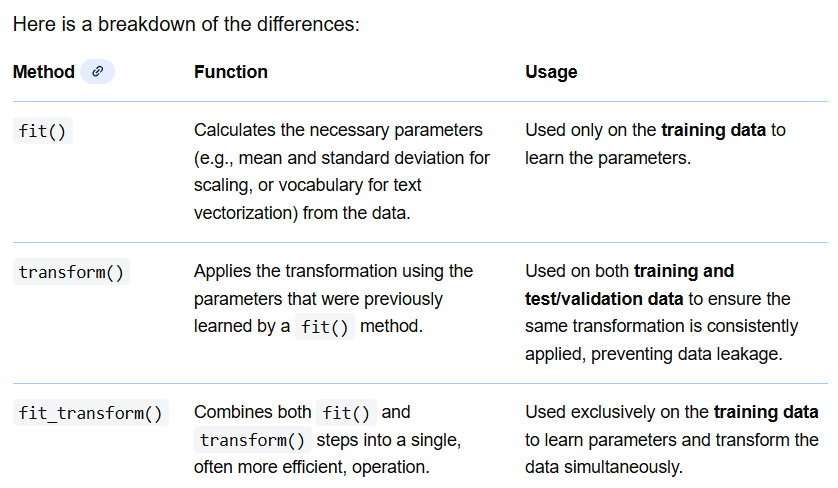 

In [14]:
vectorizer.vocabulary_

{'iveric': 15733,
 'bio': 8540,
 'announces': 7485,
 'post-hoc': 19803,
 'analysis': 7415,
 'gather1': 13804,
 'clinical': 10000,
 'trial': 24416,
 'zimura®': 26072,
 'american': 7358,
 'society': 22680,
 'retina': 21202,
 'specialists': 22843,
 'meeting': 17347,
 'https': 14929,
 ':': 6628,
 '//t.co/wbutcxok1s': 3948,
 'china': 9800,
 'refrains': 20831,
 'injecting': 15386,
 'funds': 13688,
 'banking': 8211,
 'system': 23646,
 'keeping': 16064,
 'borrowing': 8810,
 'costs': 10625,
 'unchanged': 24703,
 'signs': 22375,
 'show': 22297,
 'economy': 12061,
 'may': 17237,
 'recovering': 20759,
 'company': 10267,
 'sues': 23400,
 'elon': 12222,
 'musk': 17960,
 'trying': 24509,
 'abandon': 6665,
 '$': 2,
 '44': 5987,
 'billion': 8527,
 'deal': 11120,
 '//t.co/2bhhkvxcwa': 684,
 '@': 6633,
 'alexiskweed': 7198,
 'danielhowley': 11029,
 'unionjackracer': 24793,
 'fatjake__': 13011,
 'spx': 22960,
 'ge': 13847,
 'first': 13235,
 'world': 25791,
 'test': 23921,
 'high': 14655,
 'power': 19851,


### Test set

In [15]:
import pandas as pd

total_samples = 120

n_classes = test_df['label'].nunique()

samples_per_class = total_samples // n_classes

test_rand_df = test_df.groupby('label', group_keys=False).apply(lambda x: x.sample(samples_per_class, random_state=123)).reset_index(drop=True)

print(test_rand_df['label'].value_counts())
print(f"Total rows: {len(test_rand_df)}")

label
Analyst Update                 6
Company | Product News         6
Currencies                     6
Dividend                       6
Earnings                       6
Energy | Oil                   6
Fed | Central Banks            6
Financials                     6
General News | Opinion         6
Gold | Metals | Materials      6
IPO                            6
Legal | Regulation             6
M&A | Investments              6
Macro                          6
Markets                        6
Personnel Change               6
Politics                       6
Stock Commentary               6
Stock Movement                 6
Treasuries | Corporate Debt    6
Name: count, dtype: int64
Total rows: 120


/tmp/ipython-input-3060925383.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_rand_df = test_df.groupby('label', group_keys=False).apply(lambda x: x.sample(samples_per_class, random_state=123)).reset_index(drop=True)


In [16]:
test_rand_df.tail()

,text,label
115,Longer maturity Treasury yields have scope to ...,Treasuries | Corporate Debt
116,Italian government bonds slide as political tu...,Treasuries | Corporate Debt
117,The demand for Series I bonds has skyrocketed ...,Treasuries | Corporate Debt
118,As Treasuries rally in the wake of mounting fe...,Treasuries | Corporate Debt
119,Turkey’s state gas company gets a $929 million...,Treasuries | Corporate Debt


# Logistic Regression

In [28]:
from sklearn.linear_model import LogisticRegression

lr_text_classifier = LogisticRegression()
lr_text_classifier.fit(train_feature_vectors, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

## Evaluation

In [29]:
from sklearn.metrics import classification_report

test_feature_vectors = vectorizer.transform(X_test)
test_predictions = lr_text_classifier.predict(test_feature_vectors)
print(classification_report(test_predictions, y_test))

                             precision    recall  f1-score   support

             Analyst Update       0.52      0.65      0.58        20
     Company | Product News       0.88      0.80      0.84       374
                 Currencies       0.44      0.78      0.56         9
                   Dividend       0.88      1.00      0.93        35
                   Earnings       0.92      0.89      0.91       119
               Energy | Oil       0.74      0.91      0.82        44
        Fed | Central Banks       0.85      0.91      0.88        93
                 Financials       0.78      0.95      0.86        57
     General News | Opinion       0.85      0.69      0.76       183
  Gold | Metals | Materials       0.60      1.00      0.75         3
                        IPO       1.00      1.00      1.00         2
         Legal | Regulation       0.78      0.93      0.85        42
          M&A | Investments       0.62      0.86      0.72        35
                      Macro      

In [30]:
y_test.unique()

array(['Earnings', 'Legal | Regulation', 'Stock Commentary', 'Macro',
       'Politics', 'Analyst Update', 'Company | Product News',
       'Fed | Central Banks', 'General News | Opinion', 'Financials',
       'M&A | Investments', 'Energy | Oil', 'Personnel Change',
       'Stock Movement', 'Dividend', 'Treasuries | Corporate Debt',
       'Markets', 'Currencies', 'Gold | Metals | Materials', 'IPO'],
      dtype=object)

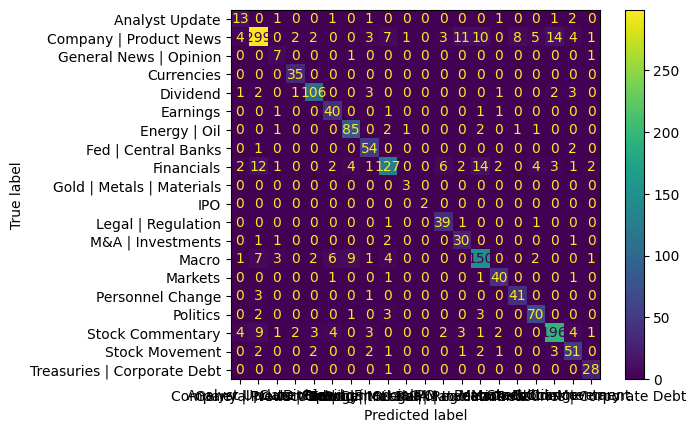

In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(test_predictions, y_test)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['Analyst Update', 'Company | Product News',
       'General News | Opinion', 'Currencies', 'Dividend', 'Earnings',
       'Energy | Oil', 'Fed | Central Banks', 'Financials',
       'Gold | Metals | Materials', 'IPO', 'Legal | Regulation',
       'M&A | Investments', 'Macro', 'Markets', 'Personnel Change',
       'Politics', 'Stock Commentary', 'Stock Movement',
       'Treasuries | Corporate Debt']
)
disp.plot()

## Analysis

In [34]:
weights = pd.DataFrame(lr_text_classifier.coef_,
                       columns=vectorizer.get_feature_names_out(),
                       index=lr_text_classifier.classes_)

In [35]:
weights

,!,#,$,%,&,','','22,'80s,'accumulation,...,🟢,🤔,🤣,🤦🏻‍♂️🤦🏻‍♂️🤦🏻‍♂️🤦🏻‍♂️🤦🏻‍♂️🤦🏻‍♂️🤦🏻‍♂️🤦🏻‍♂️🤦🏻‍♂️,🤯,🤯💥,🥇😉,🥤,🥲,🧵
Analyst Update,-0.255699,-0.428225,0.921500,-0.119500,0.554432,0.293722,0.141967,-0.000722,-0.003442,-0.002220,...,-0.001663,-0.000857,-0.011563,-0.000258,-0.000749,-0.001477,-0.002393,-0.000999,-0.006239,-0.000051
Company | Product News,0.002917,0.094273,0.107658,-0.712333,-0.249300,-0.004911,0.119106,-0.005695,-0.057250,-0.075056,...,-0.000543,-0.022050,-0.200607,0.212722,-0.017074,-0.000737,-0.006344,0.122290,-0.018224,-0.000375
Currencies,-0.128085,0.313168,-0.402021,0.221482,-0.025177,0.111192,0.063285,-0.000454,-0.002758,-0.003951,...,-0.000031,-0.028004,-0.004348,-0.004390,-0.000281,-0.000063,-0.000285,-0.001488,-0.000619,-0.000049
Dividend,-0.105815,0.018474,0.589111,0.911853,0.045253,0.205717,-0.054930,-0.001332,-0.000561,-0.000271,...,-0.000342,-0.000312,-0.001459,-0.000162,-0.002088,-0.000459,-0.000309,-0.000420,-0.001967,-0.000050
Earnings,0.160662,0.046124,0.690186,-0.988335,0.346179,-0.380231,-0.010421,-0.000110,-0.000990,-0.000314,...,-0.000068,-0.000507,-0.001508,-0.000557,-0.001511,-0.000345,-0.000634,-0.000548,-0.001177,-0.000098
Energy | Oil,0.283593,0.413737,0.033458,-0.202037,-0.283751,-0.197541,0.098678,-0.000751,-0.001216,-0.003177,...,-0.000032,0.040914,-0.011701,-0.018184,-0.004166,-0.000278,-0.009406,-0.001107,-0.003184,-0.000072
Fed | Central Banks,-0.400605,0.389941,-1.335663,0.516788,-0.507816,0.379488,0.046665,0.213984,-0.006738,-0.000647,...,-0.000031,-0.002949,-0.015830,-0.032581,-0.000096,-0.000050,-0.000176,-0.000880,-0.000332,-0.000107
Financials,-0.256894,-0.067578,0.605596,0.421932,0.057696,-0.225919,-0.191928,-0.007123,-0.001286,-0.000747,...,-0.001917,-0.000998,-0.003665,-0.000176,-0.002026,-0.001669,-0.003353,-0.000957,-0.016934,-0.000066
General News | Opinion,0.409344,-0.349947,-2.022973,-0.768641,-0.088087,0.521928,0.144152,-0.002970,0.148450,-0.016114,...,-0.000032,-0.027169,0.169668,-0.008147,-0.000894,-0.000120,-0.000620,-0.033870,-0.000971,-0.000319
Gold | Metals | Materials,0.092404,0.489454,0.364507,-0.130858,0.103301,-0.216572,-0.016654,-0.000272,-0.000793,-0.000249,...,-0.000032,-0.001790,-0.002515,-0.000618,-0.000573,-0.000232,-0.001651,-0.000476,-0.002190,-0.000046


In [36]:
weights.transpose()

,Analyst Update,Company | Product News,Currencies,Dividend,Earnings,Energy | Oil,Fed | Central Banks,Financials,General News | Opinion,Gold | Metals | Materials,IPO,Legal | Regulation,M&A | Investments,Macro,Markets,Personnel Change,Politics,Stock Commentary,Stock Movement,Treasuries | Corporate Debt
!,-0.255699,0.002917,-0.128085,-0.105815,0.160662,0.283593,-0.400605,-0.256894,0.409344,0.092404,-0.072708,-0.208981,-0.268177,0.195216,0.260597,-0.313624,-0.265723,0.675399,0.203669,-0.007487
#,-0.428225,0.094273,0.313168,0.018474,0.046124,0.413737,0.389941,-0.067578,-0.349947,0.489454,0.103752,-0.513998,-0.127343,0.125953,-0.500595,-0.517011,-0.196112,0.698164,-0.072965,0.080736
$,0.921500,0.107658,-0.402021,0.589111,0.690186,0.033458,-1.335663,0.605596,-2.022973,0.364507,0.172973,-0.059552,0.403770,-0.930965,0.186042,-0.163746,-1.058997,1.024443,0.739119,0.135555
%,-0.119500,-0.712333,0.221482,0.911853,-0.988335,-0.202037,0.516788,0.421932,-0.768641,-0.130858,-0.330036,-0.902834,-0.287882,0.832149,0.774293,-1.023719,-0.299910,-0.088374,1.985911,0.190051
&,0.554432,-0.249300,-0.025177,0.045253,0.346179,-0.283751,-0.507816,0.057696,-0.088087,0.103301,-0.025128,0.142811,-0.046521,-0.160152,0.194801,0.050660,-0.248412,0.205045,-0.345681,0.279847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
🤯💥,-0.001477,-0.000737,-0.000063,-0.000459,-0.000345,-0.000278,-0.000050,-0.001669,-0.000120,-0.000232,-0.000099,-0.000199,-0.000188,-0.000088,-0.002624,-0.000360,-0.000084,0.016433,-0.007146,-0.000214
🥇😉,-0.002393,-0.006344,-0.000285,-0.000309,-0.000634,-0.009406,-0.000176,-0.003353,-0.000620,-0.001651,-0.000466,-0.001463,-0.002130,-0.001270,-0.019682,-0.000456,-0.000857,0.058530,-0.006287,-0.000749
🥤,-0.000999,0.122290,-0.001488,-0.000420,-0.000548,-0.001107,-0.000880,-0.000957,-0.033870,-0.000476,-0.000250,-0.002204,-0.006481,-0.000525,-0.001489,-0.001787,-0.001844,-0.063276,-0.001236,-0.002453
🥲,-0.006239,-0.018224,-0.000619,-0.001967,-0.001177,-0.003184,-0.000332,-0.016934,-0.000971,-0.002190,-0.000581,-0.003398,-0.006447,-0.002338,-0.009208,-0.002413,-0.000796,0.112888,-0.032606,-0.003263


In [44]:
weights.transpose().sort_values('Currencies', ascending=False)['Currencies'][:10]

,Currencies
dollar,3.804784
euro,3.332597
rupee,1.439868
ecb,1.137127
yen,1.109281
parity,1.044888
yuan,1.030099
gains,1.004262
hike,0.962297
currency,0.934039


In [40]:
weights.transpose().loc['launches']

,launches
Analyst Update,-0.071723
Company | Product News,2.430368
Currencies,-0.034683
Dividend,-0.041324
Earnings,-0.049205
Energy | Oil,-0.073657
Fed | Central Banks,-0.087261
Financials,-0.084468
General News | Opinion,-0.367063
Gold | Metals | Materials,-0.022164


In [41]:
pd.DataFrame(lr_text_classifier.intercept_, index=lr_text_classifier.classes_)

,0
Analyst Update,-0.814711
Company | Product News,2.434450
Currencies,-0.900750
Dividend,-1.729828
Earnings,-1.964427
Energy | Oil,-0.296099
Fed | Central Banks,0.404691
Financials,-0.305646
General News | Opinion,2.722596
Gold | Metals | Materials,-1.602910


# Zero-shot LLM Classifier

In [46]:
import os
from dotenv import load_dotenv
from getpass import getpass

# Load variables from .env file
load_dotenv()

# Access the variables
TYPHOON_API_KEY = os.getenv("TYPHOON_API_KEY")
if TYPHOON_API_KEY is None:
    TYPHOON_API_KEY = getpass("Enter Typhoon API Key:")

GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
if GOOGLE_API_KEY is None:
    GOOGLE_API_KEY = getpass("Enter Google API Key:")

In [47]:
import re

def clean_text(text):
    text = re.sub(r'\|', '', text)

    return text

## Typhoon

In [ ]:
from openai import OpenAI

def analyze_topic_typhoon(text):

    client = OpenAI(
        api_key=TYPHOON_API_KEY,
        base_url='https://api.opentyphoon.ai/v1'
    )

    messages = [
        {
            "role": "system", 
            "content": """You are an expert Financial News Editor and Data Classifier. 
            Classify the provided financial news headline list from user's prompt into exactly one of the following 20 categories: 
            
            'Analyst Update', 
            'Company | Product News',
            'General News | Opinion', 
            'Currencies', 
            'Dividend', 
            'Earnings',
            'Energy | Oil', 
            'Fed | Central Banks', 
            'Financials',
            'Gold | Metals | Materials', 
            'IPO', 
            'Legal | Regulation',
            'M&A | Investments', 
            'Macro', 
            'Markets', 
            'Personnel Change',
            'Politics', 
            'Stock Commentary', 
            'Stock Movement',
            'Treasuries | Corporate Debt'

            Each of output must be label string only.

            Given response as json array format
            """
        },
        {
            "role": "User",
            "content": text
        }
    ]

    response = client.chat.completions.create(
        model="typhoon-v2.5-30b-a3b-instruct",
        messages=messages,
    )

    return response.choices[0].message.content

In [59]:
text = clean_text(X_test[4768])
print(text)
print(analyze_topic_typhoon(text))

Emera Teleconference on August 10 to Discuss Q2 2022 Results  https://t.co/KoJxf8sSP9  
Stock Movement


In [60]:
print(y_test[4768])

Earnings


In [64]:
import json

typhoon_response = json.load(analyze_topic_typhoon(list(X_test)))
print(type(typhoon_response))
print(len(typhoon_response))

InternalServerError: Error code: 500 - {'detail': "Can't process the request, please try again later."}

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(test_preds_typhoon, test_rand_df['label']))

## Gemini

In [ ]:
from google import genai
from google.genai import types

def analyze_topic_gemini(text):

    client = genai.Client(
        api_key=GOOGLE_API_KEY,
    )

    response = client.models.generate_content(
        model="gemini-3-flash-preview",
        config=types.GenerateContentConfig(
            system_instruction="""You are an expert News Editor and Data Classifier. 
            Classify the provided news headline from user's prompt into exactly one of the following 6 categories: 
            'การเมือง', 'สิ่งแวดล้อม', 'ต่างประเทศ', 'คุณภาพชีวิต', 'เศรษฐกิจ', 'สังคม'. 
            Output must be label string only.
            """
        ),
        contents=text
    )

    return response.text

In [ ]:
text = clean_text(test_rand_df['title tokens'].loc[0])
print(text)
print(analyze_topic_gemini(text))

In [ ]:
test_preds_gemini = []

for text in test_rand_df['title tokens']:
    text = clean_text(text)
    gemini_label = analyze_topic_gemini(text)
    test_preds_gemini.append(gemini_label)

In [ ]:
print(test_preds_gemini)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(test_preds_gemini, test_rand_df['label']))